# Agentic RAG - Corrective RAG Agent
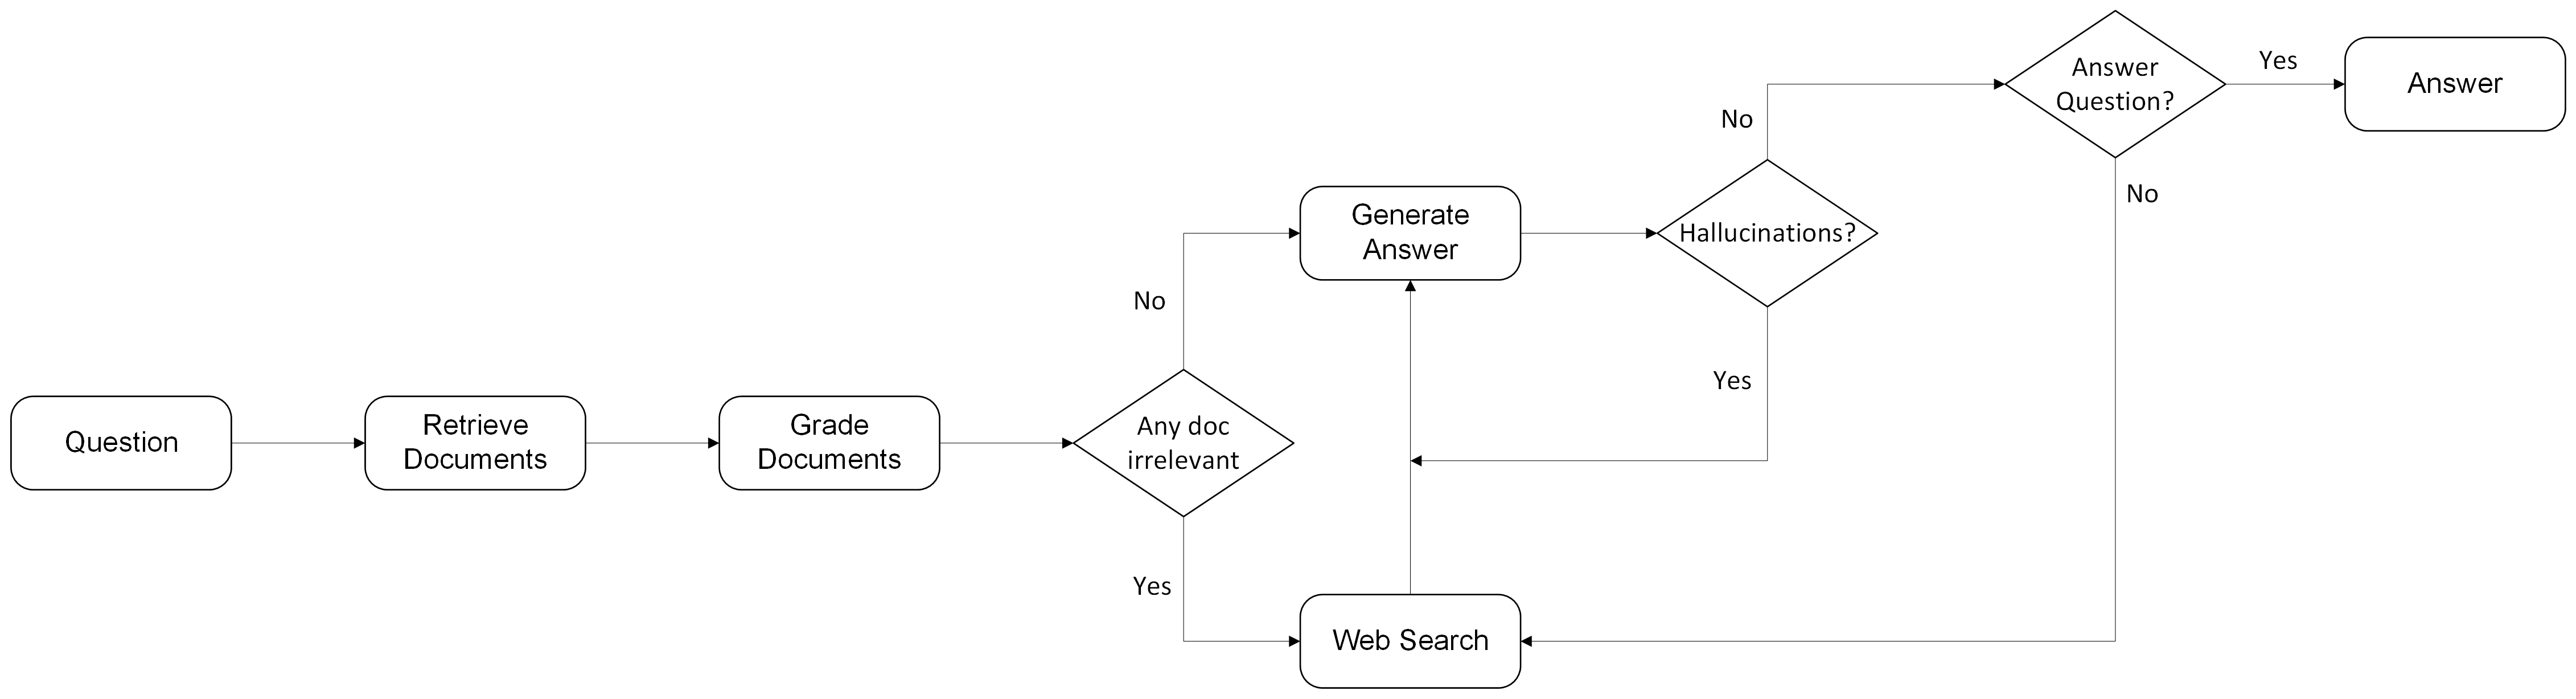

In [1]:
import os
from dotenv import load_dotenv

from typing import List
from pprint import pprint
from firecrawl import FirecrawlApp
from typing_extensions import TypedDict
from IPython.display import Image, display

from langsmith import Client
from langchain_groq import ChatGroq
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

load_dotenv()

tavily_api_key = os.getenv("TAVILY_API_KEY")
firecrawl_api_key = os.getenv("FIRECRAWL_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
client = Client(api_key=langchain_api_key)

llm_model = "meta-llama/llama-4-scout-17b-16e-instruct"
llm = ChatGroq(model=llm_model, temperature=0, groq_api_key=groq_api_key)

grader_llm = ChatGroq(
    model=llm_model,
    temperature=0,
    groq_api_key=groq_api_key,
    model_kwargs={'response_format': {'type': 'json_object'}}
)

web_search_tool = TavilySearchResults(k=3, api_key=tavily_api_key)

### Data Loading and Vector Store
Scraping web content and indexing it into a local Chroma vector database

In [2]:
urls = [
    "https://blog.langchain.dev/agentic-design-patterns/",
    "https://emizentech.com/blog/strategies-to-reduce-llm-applications-costs.html",
]

app = FirecrawlApp(api_key=firecrawl_api_key)

docs_list = []
for url in urls:
    scraped_data = app.scrape_url(url)
    document = Document(
        page_content=scraped_data.markdown,
        metadata={'source': url}
    )
    docs_list.append(document)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to the vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma-agentic",
    embedding=GPT4AllEmbeddings(),
)
retriever = vectorstore.as_retriever()

print(f"\nSuccessfully loaded and indexed {len(docs_list)} document(s).")


Successfully loaded and indexed 2 document(s).


### Grader and Generation Chains

In [3]:
# 1. Retrieval Grader: Checks if the document is relevant to the question.
prompt_retrieval_grader = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing the relevance of a retrieved document to a user question.
    If the document contains keywords related to the user question, grade it as relevant.
    The goal is to filter out erroneous retrievals.
    Give a binary "yes" or "no" score.
    Provide the binary score as a JSON with a single key "score" and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Retrieved document: \n\n {document} \n\n
    User question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)
retrieval_grader = prompt_retrieval_grader | grader_llm | JsonOutputParser()

# 2. Hallucination Grader: Checks if the answer is grounded in the provided facts.
prompt_hallucination_grader = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is grounded in/supported by a set of facts.
    Give a binary "yes" or "no" score.
    Provide the binary score as a JSON with a single key "score" and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Facts: \n\n {documents} \n\n
    Answer: {generation} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
hallucination_grader = prompt_hallucination_grader | grader_llm | JsonOutputParser()

# 3. Answer Grader: Checks if the answer addresses the user's question.
prompt_answer_grader = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer addresses the user's question.
    Give a binary "yes" or "no" score.
    Provide the binary score as a JSON with a single key "score" and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    User question: {question} \n\n
    Generated answer: {generation} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "generation"],
)
answer_grader = prompt_answer_grader | grader_llm | JsonOutputParser()

# 4. RAG Generation Chain: Generates the final answer.
prompt_rag = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "context"],
)
rag_chain = prompt_rag | llm | StrOutputParser()

### Graph State

In [4]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The user's question.
        generation: The LLM's generated answer.
        web_search: A flag indicating whether a web search is needed.
        documents: A list of retrieved documents.
    """
    question : str
    generation : str
    web_search : str
    documents : List[Document]

### Graph Nodes

In [5]:
def retrieve(state):
    """Retrieve documents from the vector store."""
    print("---NODE: RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Sets a flag to perform a web search if any document is not relevant.
    """
    print("---NODE: GRADE DOCUMENTS---")
    question = state["question"]
    documents = state["documents"]
    
    filtered_docs = []
    web_search_needed = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search_needed = "Yes"
    
    return {"documents": filtered_docs, "web_search": web_search_needed, "question": question}

def generate(state):
    """Generate an answer using the retrieved documents."""
    print("---NODE: GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def web_search(state):
    """Perform a web search and add the results to the list of documents."""
    print("---NODE: WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    
    web_results = web_search_tool.invoke({"query": question})
    documents.extend([Document(page_content=d["content"], metadata={"source": d["url"]}) for d in web_results])
    
    return {"documents": documents, "question": question}

### Graph Conditional Edges

In [6]:
def decide_to_generate(state):
    """Determines whether to generate an answer or perform a web search."""
    print("---EDGE: DECIDE TO GENERATE---")
    if state["web_search"] == "Yes":
        print("---DECISION: Documents not relevant, routing to web search.---")
        return "websearch"
    else:
        print("---DECISION: Relevant documents found, routing to generation.---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines if the generation is grounded and useful.
    Routes to re-generation, web search, or finishes the process.
    """
    print("---EDGE: GRADE GENERATION---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # Hallucination check
    hallucination_score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    if hallucination_score['score'].lower() == "no":
        print("---DECISION: Generation is not grounded. Re-generating.---")
        return "not supported"

    # Answer usefulness check
    answer_score = answer_grader.invoke({"question": question, "generation": generation})
    if answer_score['score'].lower() == "no":
        print("---DECISION: Generation does not answer the question. Routing to web search.---")
        return "not useful"
    
    print("---DECISION: Generation is useful. Finishing.---")
    return "useful"

### Build and Visualize the Graph

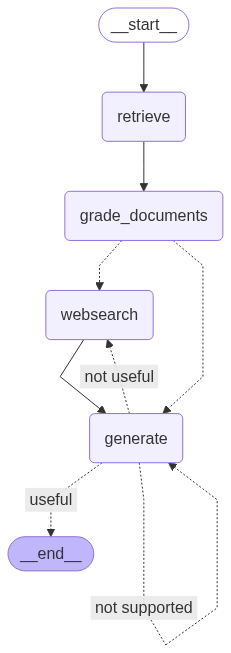

In [7]:
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("websearch", web_search)

# Set the entry point and define the edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)

workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "not useful": "websearch",
        "useful": END,
    },
)

app = workflow.compile()

image_bytes = app.get_graph().draw_mermaid_png()
display(Image(image_bytes))

### Run the Agent

In [8]:
inputs = {"question": "How can one reduce the operational costs associated with large language models?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

print("\n---FINAL ANSWER---")
pprint(value["generation"])

---NODE: RETRIEVE---
'Finished running: retrieve:'
---NODE: GRADE DOCUMENTS---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---EDGE: DECIDE TO GENERATE---
---DECISION: Relevant documents found, routing to generation.---
'Finished running: grade_documents:'
---NODE: GENERATE---
---EDGE: GRADE GENERATION---
---DECISION: Generation is useful. Finishing.---
'Finished running: generate:'

---FINAL ANSWER---
('To reduce operational costs associated with large language models, one can '
 'optimize model selection and usage by choosing a model that balances '
 'performance and cost. Using simpler models for specific tasks can also save '
 'money and benefit from faster processing power and reduced computational '
 'resources. Additionally, implementing efficient fine-tuning techniques can '
 'help adapt pre-trained models to specific tasks or domains, reducing costs.')
